In [1]:
from keras.optimizers import Adam
from keras.models import Model
from keras import backend as K
from datetime import datetime
import distutils.dir_util
from keras.callbacks import CSVLogger
from keras.utils.np_utils import to_categorical
import numpy as np

from keras import __version__
print(__version__)

Using TensorFlow backend.


2.0.3


In [2]:
from keras.layers import Dense, Input, Lambda, BatchNormalization, Conv2D, ZeroPadding2D, MaxPooling2D, AveragePooling2D, Activation, Flatten, Dropout
from keras.applications.resnet50 import ResNet50

resnet_base = ResNet50(include_top=False, weights='imagenet')

#classifier_input_shape = resnet_base.layers[-1].output_shape[1:] 
# i.e. shape of conv features (produces (None, None, None, 2048))
classifier_input_shape = (1, 1, 2048)
classifier_input = Input(shape=classifier_input_shape)

In [3]:
from keras.preprocessing.image import ImageDataGenerator
def preprocess_input(x, data_format=None):
    """Preprocesses a tensor encoding a batch of images.
    # Arguments
        x: input Numpy tensor, 4D.
        data_format: data format of the image tensor.
    # Returns
        Preprocessed tensor.
    """

    # 'RGB'->'BGR'
    x = x[:, :, ::-1]
    # Zero-center by mean pixel
    x[:, :, 0] -= 103.939
    x[:, :, 1] -= 116.779
    x[:, :, 2] -= 123.68
    return x

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1.25)

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

#batch_size = 32

train_generator = train_datagen.flow_from_directory(
        '/home/ubuntu/data/fishing/train',
        target_size=(224, 224),
        batch_size=28,
        #batch_size=batch_size,
        shuffle=False,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        '/home/ubuntu/data/fishing/valid',
        target_size=(224, 224),
        shuffle=False,
        #batch_size=batch_size,
        batch_size=20,
        class_mode='categorical')

Found 3276 images belonging to 8 classes.
Found 500 images belonging to 8 classes.


In [4]:
def create_precomputed_data(model, batches):
    filenames = batches.filenames
    conv_features = model.predict_generator(batches, (batches.samples/batches.batch_size ))
    #conv_features = model.predict_generator(batches,
     #                              len(batches.filenames))
    labels_onehot = to_categorical(batches.classes)
    labels = batches.classes
    return (filenames, conv_features, labels_onehot, labels)

In [5]:
trn_filenames, trn_conv_features, trn_labels, trn_labels_1 = create_precomputed_data(resnet_base, train_generator)
val_filenames, val_conv_features, val_labels, val_labels_1 = create_precomputed_data(resnet_base, validation_generator)

In [6]:
print trn_conv_features.shape
print val_conv_features.shape

(3276, 1, 1, 2048)
(500, 1, 1, 2048)


In [7]:

assert len(trn_filenames) == 3276, "trn_filenames not as expected"
assert trn_conv_features.shape == (3276, 1, 1, 2048), "trn_conv_features not as expected"
assert trn_labels.shape == (3276, 8), "trn_labels not as expected"

assert len(val_filenames) == 500, "val_filenames not as expected"
assert val_conv_features.shape == (500, 1, 1, 2048), "val_conv_features not as expected"
assert val_labels.shape == (500, 8), "val_labels not as expected"


In [8]:
RESULTS_DIR = '/home/ubuntu/data/fishing/results'

In [9]:

import bcolz
def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()

def save_precomputed_data(filenames, conv_feats, labels, features_base_name="ResNet50_conv_feats/trn_"):
    save_array(RESULTS_DIR+"/"+features_base_name+'filenames.dat', np.array(filenames))
    save_array(RESULTS_DIR+"/"+features_base_name+'conv_feats.dat', conv_feats)
    save_array(RESULTS_DIR+"/"+features_base_name+'labels.dat', np.array(labels))
    
save_precomputed_data(trn_filenames, trn_conv_features, trn_labels, "ResNet50_conv_feats/trn_")
save_precomputed_data(val_filenames, val_conv_features, val_labels, "ResNet50_conv_feats/val_")

In [10]:
import bcolz
def load_array(fname):
    return bcolz.open(fname)[:]

def load_precomputed_data(features_base_name="ResNet50_conv_feats/trn_"):
    filenames = load_array(RESULTS_DIR+"/"+features_base_name+'filenames.dat').tolist()
    conv_feats = load_array(RESULTS_DIR+"/"+features_base_name+'conv_feats.dat')
    labels = load_array(RESULTS_DIR+"/"+features_base_name+'labels.dat')
    return filenames, conv_feats, labels

trn_filenames, trn_conv_features, trn_labels = load_precomputed_data("ResNet50_conv_feats/trn_")
val_filenames, val_conv_features, val_labels = load_precomputed_data("ResNet50_conv_feats/val_")

In [11]:
# Create classifier model

x= Flatten()(classifier_input)
x = Dense(8, activation='softmax')(x)
                                                     
classifier_model_v1 = Model(classifier_input, x)

#from keras.optimizers import SGD
classifier_model_v1.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:

def fit_precomputed_helper(model, result_dir_name, lr=0.1, nb_epoch=1):  
    K.set_value(model.optimizer.lr, lr)
    
    now = datetime.now().strftime("%Y%m%d_%H%M%S.h5")
    results_dir = RESULTS_DIR + "/" + result_dir_name + "/"
    distutils.dir_util.mkpath(results_dir)
    
    model.fit(trn_conv_features, trn_labels,
              batch_size=32, 
              epochs=nb_epoch,
              validation_data=(val_conv_features, val_labels),
              shuffle=True, 
              callbacks=[CSVLogger(results_dir+"epoch_results.csv", separator=',', append=True)])
    model.save_weights(results_dir + now)
    return model

In [13]:
classifier_model_v1 = fit_precomputed_helper(classifier_model_v1, "classifier_model_v1", lr=0.01, nb_epoch=10)
# run 4 times

Train on 3276 samples, validate on 500 samples
Epoch 1/10
3276/3276 [==============================] - 0s - loss: 5.2972 - acc: 0.5018 - val_loss: 5.4877 - val_acc: 0.5640
Epoch 2/10
3276/3276 [==============================] - 0s - loss: 4.5791 - acc: 0.6496 - val_loss: 5.1919 - val_acc: 0.5880
Epoch 3/10
3276/3276 [==============================] - 0s - loss: 4.4907 - acc: 0.6627 - val_loss: 5.1170 - val_acc: 0.6220
Epoch 4/10
3276/3276 [==============================] - 0s - loss: 4.4446 - acc: 0.6767 - val_loss: 5.4195 - val_acc: 0.5580
Epoch 5/10
3276/3276 [==============================] - 0s - loss: 4.3662 - acc: 0.6947 - val_loss: 5.3430 - val_acc: 0.5720
Epoch 6/10
3276/3276 [==============================] - 0s - loss: 4.3799 - acc: 0.6911 - val_loss: 5.0228 - val_acc: 0.6340
Epoch 7/10
3276/3276 [==============================] - 0s - loss: 4.3222 - acc: 0.7085 - val_loss: 5.2362 - val_acc: 0.6000
Epoch 8/10
3276/3276 [==============================] - 0s - loss: 4.3224 - ac

In [14]:
results_dir = 'classifier_model_v2'
distutils.dir_util.mkpath(results_dir)
classifier_model_v2 = classifier_model_v1
mdl_test_adding_class_weights = classifier_model_v2.fit(trn_conv_features, trn_labels,
                                          batch_size=32, 
                                          epochs=5,
                                          validation_data=(val_conv_features, val_labels),
                                          shuffle=True,
#                                           class_weight = {0: 220.,1: 1888.,2: 3227., 3: 5636., 4: 812., 5: 1263., 6: 2145., 7: 514.},
                                          class_weight = {0: 1., 1: 2., 2: 3., 3: 5., 4: 1., 5: 1., 6: 1., 7: 1.},
                                          callbacks=[CSVLogger(results_dir+"epoch_results.csv", separator=',', append=True)])

Train on 3276 samples, validate on 500 samples
Epoch 1/5
3276/3276 [==============================] - 0s - loss: 6.4465 - acc: 0.7170 - val_loss: 5.1530 - val_acc: 0.6100
Epoch 2/5
3276/3276 [==============================] - 0s - loss: 6.4053 - acc: 0.7317 - val_loss: 5.0449 - val_acc: 0.6400
Epoch 3/5
3276/3276 [==============================] - 0s - loss: 6.4144 - acc: 0.7323 - val_loss: 5.3648 - val_acc: 0.5900
Epoch 4/5
3276/3276 [==============================] - 0s - loss: 6.4757 - acc: 0.6822 - val_loss: 4.9948 - val_acc: 0.6400
Epoch 5/5
3276/3276 [==============================] - 0s - loss: 6.3505 - acc: 0.6957 - val_loss: 5.2549 - val_acc: 0.6160


In [15]:
p = 0.7

In [16]:
# Create classifier model
      
x = Flatten()(classifier_input)
x = BatchNormalization(axis=1)(x)
x = Dropout(p/4)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(8, activation='softmax')(x)
                                                     
classifier_model_v3 = Model(classifier_input, x)

#from keras.optimizers import SGD
classifier_model_v3.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
classifier_model_v3 = fit_precomputed_helper(classifier_model_v3, "classifier_model_v3", lr=0.001, nb_epoch=10)
# run 3 times

Train on 3276 samples, validate on 500 samples
Epoch 1/10
3276/3276 [==============================] - 1s - loss: 0.1067 - acc: 0.9646 - val_loss: 0.4117 - val_acc: 0.9080
Epoch 2/10
3276/3276 [==============================] - 1s - loss: 0.1021 - acc: 0.9676 - val_loss: 0.3804 - val_acc: 0.9200
Epoch 3/10
3276/3276 [==============================] - 1s - loss: 0.0914 - acc: 0.9692 - val_loss: 0.3473 - val_acc: 0.9260
Epoch 4/10
3276/3276 [==============================] - 1s - loss: 0.0871 - acc: 0.9725 - val_loss: 0.3835 - val_acc: 0.9220
Epoch 5/10
3276/3276 [==============================] - 1s - loss: 0.0903 - acc: 0.9692 - val_loss: 0.3206 - val_acc: 0.9240
Epoch 6/10
3276/3276 [==============================] - 1s - loss: 0.1041 - acc: 0.9667 - val_loss: 0.3196 - val_acc: 0.9380
Epoch 7/10
3276/3276 [==============================] - 1s - loss: 0.1087 - acc: 0.9689 - val_loss: 0.3105 - val_acc: 0.9380
Epoch 8/10
3276/3276 [==============================] - 1s - loss: 0.1212 - ac

In [153]:
classifier_model_v3.save_weights('/home/ubuntu/git/learningWithKaggle/weights/fishing/ft_resnet93_valid.h5')

In [154]:
# submit prediction on test data
# try a more complex model? with some regularisation such as dropout and batchnorm
# balance the validation set

mdl_test_adding_class_weights = classifier_model_v3.fit(trn_conv_features, trn_labels,
                                          batch_size=32, 
                                          epochs=5,
                                          validation_data=(val_conv_features, val_labels),
                                          shuffle=True)
#                                           class_weight = {0: 220.,1: 1888.,2: 3227., 3: 5636., 4: 812., 5: 1263., 6: 2145., 7: 514.},
#                                           class_weight = {0: 1., 1: 2., 2: 3., 3: 5., 4: 1., 5: 1., 6: 1., 7: 1.})

Train on 3276 samples, validate on 500 samples
Epoch 1/5
3276/3276 [==============================] - 1s - loss: 0.3380 - acc: 0.8843 - val_loss: 4.2161 - val_acc: 0.4180
Epoch 2/5
3276/3276 [==============================] - 1s - loss: 0.3225 - acc: 0.8828 - val_loss: 4.2175 - val_acc: 0.4160
Epoch 3/5
3276/3276 [==============================] - 1s - loss: 0.3019 - acc: 0.8944 - val_loss: 4.1092 - val_acc: 0.4200
Epoch 4/5
3276/3276 [==============================] - 1s - loss: 0.2920 - acc: 0.8926 - val_loss: 4.1957 - val_acc: 0.4180
Epoch 5/5
3276/3276 [==============================] - 1s - loss: 0.2963 - acc: 0.8950 - val_loss: 4.1511 - val_acc: 0.4180


In [24]:
classifier_model_v3.optimizer.lr = 0.01

In [ ]:
# find images which are misclassified

In [46]:
len(mdl_test_adding_class_weights.validation_data)

4

In [48]:
classifier_model_v3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1, 1, 2048)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 2048)              8192      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1049088   
_________________________________________________________________
batch_normalization_3 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

In [41]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
real_test_gen = test_datagen.flow_from_directory(
        '/home/ubuntu/data/fishing/test_stg1',
        target_size=(224, 224),
        batch_size=10,
        shuffle=False,
        class_mode=None)

Found 1000 images belonging to 1 classes.


In [20]:
val_pred_all = classifier_model_v3.predict(val_conv_features)
val_pred_all[2:]

array([[  9.55159485e-01,   3.51474819e-06,   8.89180774e-06, ...,
          1.14677619e-04,   3.35950535e-05,   1.34513111e-05],
       [  9.99987364e-01,   6.55581474e-08,   5.08016797e-07, ...,
          1.00625466e-05,   6.71717657e-07,   5.22045163e-09],
       [  9.98913646e-01,   4.83812710e-06,   3.57226577e-06, ...,
          7.74919390e-05,   8.84653764e-06,   5.59149812e-05],
       ..., 
       [  4.58073569e-04,   1.98022855e-04,   2.04572061e-05, ...,
          5.56801706e-06,   1.07638771e-03,   9.98196423e-01],
       [  4.88346341e-09,   3.12922361e-06,   1.32161895e-05, ...,
          8.46161682e-04,   4.29113470e-06,   9.99130547e-01],
       [  9.95483948e-04,   4.67658210e-05,   1.73499109e-04, ...,
          1.73431872e-05,   1.15185412e-05,   9.98684704e-01]], dtype=float32)

In [23]:
import pandas as pd
files_np = np.array(val_filenames)
labels_np = np.array(val_labels_1)
preds_np = np.round(np.clip(val_pred_all, 0.2, 0.8, out=val_pred_all), decimals=3)

# files_df.join(labels)

In [24]:
preds_np[:2]

array([[ 0.80000001,  0.2       ,  0.2       ,  0.2       ,  0.2       ,
         0.2       ,  0.2       ,  0.2       ],
       [ 0.80000001,  0.2       ,  0.2       ,  0.2       ,  0.2       ,
         0.2       ,  0.2       ,  0.2       ]], dtype=float32)

In [25]:
validation_generator.class_indices

{'ALB': 0,
 'BET': 1,
 'DOL': 2,
 'LAG': 3,
 'NoF': 4,
 'OTHER': 5,
 'SHARK': 6,
 'YFT': 7}

In [26]:
val_np = pd.DataFrame(np.column_stack((preds_np,files_np, labels_np,))).round({'0':2})
val_np[350:400]

class_list ={'ALB': 0,
 'BET': 1,
 'DOL': 2,
 'LAG': 3,
 'NoF': 4,
 'OTHER': 5,
 'SHARK': 6,
 'YFT': 7}
class_list

{'ALB': 0,
 'BET': 1,
 'DOL': 2,
 'LAG': 3,
 'NoF': 4,
 'OTHER': 5,
 'SHARK': 6,
 'YFT': 7}

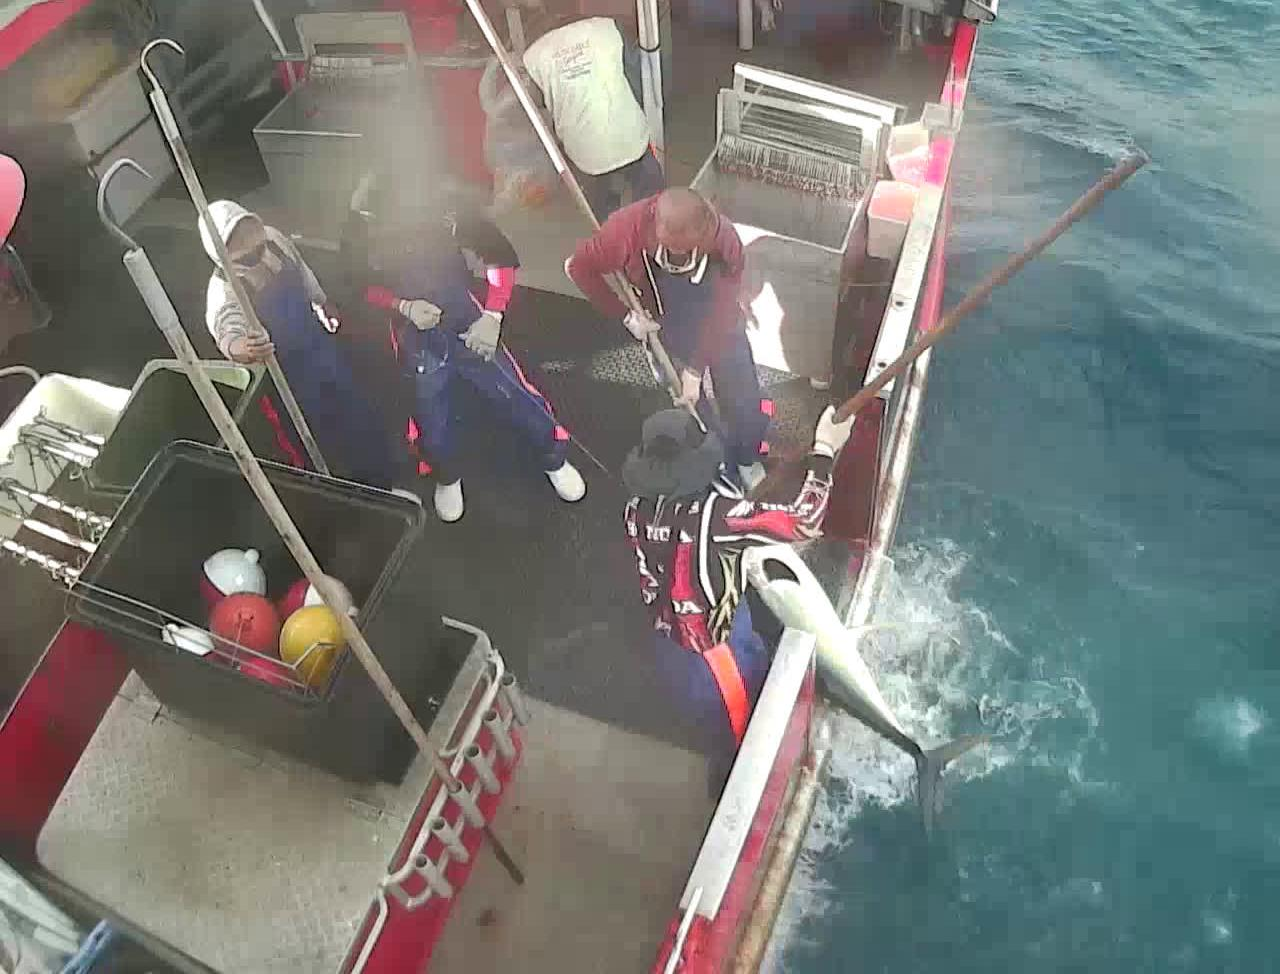

In [27]:
from IPython.display import Image

img_path = '/home/ubuntu/data/fishing/valid/YFT/img_01335.jpg'

Image(filename=img_path) 

In [102]:
# undo the one hot encoding to make it easier for the comparison

a = preds_np
b = np.zeros_like(a)

b[np.arange(len(a)), a.argmax(1)] = 1
pred_labels = b.argmax(axis=1)

df = pd.DataFrame(np.column_stack((pred_labels,labels_np,files_np)), columns=['pred_labels', 'label', 'files'])
wrong = df[(df['pred_labels']!=df['label'])]

In [103]:
import PIL

def img2array(im):
    if im.mode != 'RGB':
        im = im.convert(mode='RGB')
    return np.fromstring(im.tobytes(), dtype='uint8').reshape((im.size[1], im.size[0], 3))
    

In [91]:
wrong

,pred_labels,label,files
38,4,0,ALB/img_07096.jpg
63,7,0,ALB/img_00523.jpg
121,1,0,ALB/img_01363.jpg
135,4,0,ALB/img_05550.jpg
161,4,0,ALB/img_06693.jpg
162,4,0,ALB/img_00039.jpg
198,4,0,ALB/img_05823.jpg
224,0,1,BET/img_07007.jpg
231,0,1,BET/img_05069.jpg
264,0,4,NoF/img_00904.jpg


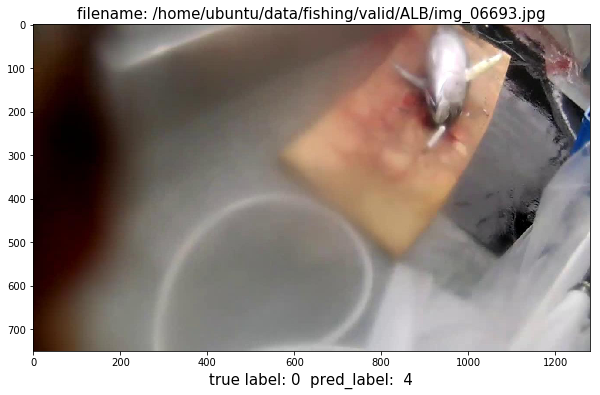

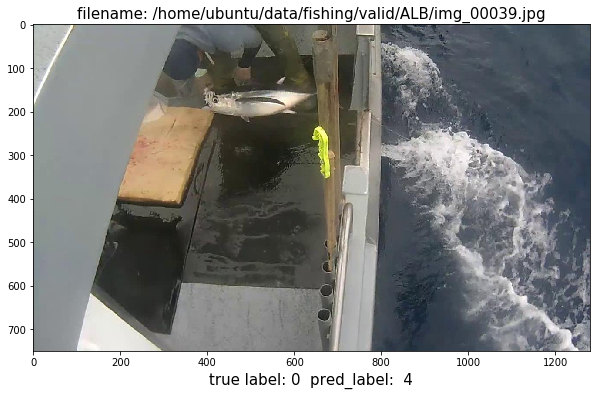

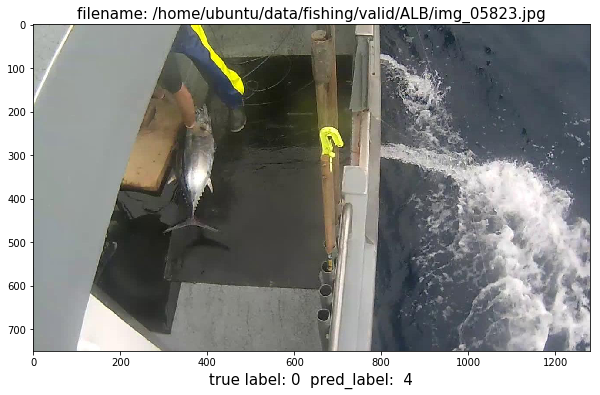

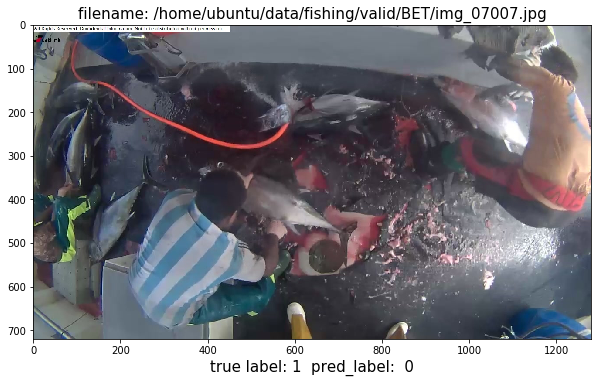

In [114]:
import matplotlib.pyplot as plt

plt.close()
files_list = []
labels_list = []
pred_labels_list = []

for (files, label, pred_label) in zip(wrong.files, wrong.label, wrong.pred_labels):
    dir_ = '/home/ubuntu/data/fishing/valid/'
    file_ = dir_+files
    files_list.append(file_)
    labels_list.append(label)
    pred_labels_list.append(pred_label)

    
files_list_sub = files_list[4:8]
labels_list_sub = labels_list[4:8]
pred_labels_list_sub = pred_labels_list[4:8]

images = [ PIL.Image.open(f) for f in files_list_sub]
np_images = [ img2array(im) for im in images ]

for (img, filen, label, pred_label) in zip(np_images, files_list_sub, labels_list_sub, pred_labels_list_sub):
    plt.figure(figsize=(10,6))
    plt.imshow(img)
    plt.title("filename: "+filen, fontsize=15)
#     print(label., pred_label)
    plt.xlabel("true label: "+label + "  pred_label:  "+pred_label, fontsize=15) 
    
plt.show()
